# Gaussian Mixture based on Time separation

## ============ Defining functions ================

In [1]:
import seaborn as sns
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.mixture import GaussianMixture
from matplotlib.colors import LogNorm
import matplotlib.gridspec as gridspec

%matplotlib inline

In [2]:
def reconstruct_sample(n, mean_x, mean_y, scale, w, size=1500):
    reconstruction_sample = []
    for i in range(n):
        xs = np.random.normal(loc=mean_x.iloc[i], scale=scale.iloc[i], size=int(size*w.iloc[i]))
        ys = np.random.normal(loc=mean_y.iloc[i], scale=scale.iloc[i], size=int(size*w.iloc[i]))
        reconstruction_sample.extend(np.vstack((xs,ys)).T)

    reconstruction_sample = np.array(reconstruction_sample)
    return reconstruction_sample

In [3]:
df = pd.read_csv('encuesta_corregida.csv')

df = df.loc[(df.MUNICIPIO_DESTINO == 'BOGOTA-DC 11001') & (df.MUNICIPIO_ORIGEN == 'BOGOTA-DC 11001') & (df.MEDIO_PREDOMINANTE == 'TAXI')]
df.loc[df.HORA_FIN.str.contains("24:00:00"), "HORA_FIN"] = "00:00:00"
df.loc[:,'HORA_FIN'] = pd.to_datetime(df.HORA_FIN, format="%H:%M:%S")
df.loc[:,'HORA_INICIO'] = pd.to_datetime(df.HORA_INICIO, format="%H:%M:%S")

df = df.loc[(df.MUNICIPIO_DESTINO == 'BOGOTA-DC 11001') & (df.MUNICIPIO_ORIGEN == 'BOGOTA-DC 11001') & (df.MEDIO_PREDOMINANTE == 'TAXI')]

In [4]:
boundaries = pd.read_csv("../../distributions/boundaries.csv")

In [6]:
df.loc[:,'x_coord_org'] = (df.x_coord_org - boundaries.x_min[0]) / (boundaries.x_max[0] - boundaries.x_min[0]) * 30 * ((boundaries.x_max[0] - boundaries.x_min[0]) / (boundaries.y_max[0] - boundaries.y_min[0]))
df.loc[:,'y_coord_org'] = (df.y_coord_org - boundaries.y_min[0]) / (boundaries.y_max[0] - boundaries.y_min[0]) * 30 

df.loc[:,'x_coord_dest'] = (df.x_coord_dest - boundaries.x_min[0]) / (boundaries.x_max[0] - boundaries.x_min[0]) * 30 * ((boundaries.x_max[0] - boundaries.x_min[0]) / (boundaries.y_max[0] - boundaries.y_min[0]))
df.loc[:,'y_coord_dest'] = (df.y_coord_dest - boundaries.y_min[0]) / (boundaries.y_max[0] - boundaries.y_min[0]) * 30

In [7]:
def generate_gm(n, df, time_zones, inicio = True):
    
    to_csv = pd.DataFrame(columns=['max_hour','w_cumulative', 'w','std','mean_x','mean_y'])
    
    variable = "HORA_FIN"
    variable2 = "dest"
    if inicio : 
        variable = "HORA_INICIO"
        variable2 = "org"
    
    last_max_time = -1

    for max_time in time_zones:

        df_temp = df.loc[(df[variable].dt.hour > last_max_time) & (df[variable].dt.hour <= max_time)]
        to_csv_temp = pd.DataFrame(index=range(n), columns=['max_hour','w','w_cumulative','std','mean_x','mean_y'])

        gmb = GaussianMixture(n, max_iter=10000, covariance_type="spherical")
        gmb.fit(df_temp.loc[:,['x_coord_'+variable2,'y_coord_'+variable2]].values.reshape(-1, 2));

        cumulative_w = []
        w = 0
        for weight in gmb.weights_:
            w += weight
            cumulative_w.append(w)

        to_csv_temp.loc[:,'max_hour'] = max_time
        to_csv_temp.loc[:,'w'] = gmb.weights_
        to_csv_temp.loc[:,'w_cumulative'] = cumulative_w
        to_csv_temp.loc[:,'std'] = gmb.covariances_ ** 0.5
        to_csv_temp.loc[:,['mean_x', 'mean_y']] = gmb.means_

        to_csv = pd.concat([to_csv,to_csv_temp], ignore_index=True)

        last_max_time = max_time
        
    return to_csv

## Generating plots

In [8]:
def generate_single_dist_plts(n, df, gm_df, time_zones, inicio = True):
    variable = "HORA_FIN"
    variable2 = "dest"
    if inicio : 
        variable = "HORA_INICIO"
        variable2 = "org"
    
    last_max_time = -1

    fig, axs = plt.subplots(len(time_zones),2)
    fig.set_figheight(7)
    fig.set_figwidth(7)
    plt.tight_layout(h_pad=3)

    for i, max_time in enumerate(time_zones):
        reconstructed = reconstruct_sample(n, gm_df.loc[gm_df.max_hour == max_time,'mean_x'], gm_df.loc[gm_df.max_hour == max_time, 'mean_y'], gm_df.loc[gm_df.max_hour == max_time,'std'], gm_df.loc[gm_df.max_hour == max_time,'w'], size=1500)

        df_temp = df.loc[(df[variable].dt.hour > last_max_time) & (df[variable].dt.hour <= max_time)]

        title = "" + str(last_max_time+1) + ":00h - " + str(max_time) + ":59h"

        sns.distplot(reconstructed.T[0],ax=axs[i,0])
        sns.distplot(df_temp['x_coord_'+variable2], ax=axs[i,0])
        axs[i,0].set_title(title + " - x coord")
        axs[i,0].set_xlabel("")

        sns.distplot(reconstructed.T[1],ax=axs[i,1])
        sns.distplot(df_temp['y_coord_'+variable2], ax=axs[i,1])
        axs[i,1].set_title(title + " - y coord")
        axs[i,1].set_xlabel("")

        last_max_time = max_time

In [9]:
def generate_dist_plts(n, df, gm_df, time_zones, inicio = True):
    variable = "HORA_FIN"
    variable2 = "dest"
    if inicio : 
        variable = "HORA_INICIO"
        variable2 = "org"
    
    last_max_time = -1

    fig, axs = plt.subplots(len(time_zones),2)

    fig.set_figheight(10)
    fig.set_figwidth(7)
    plt.tight_layout(h_pad=4)

    for i, max_time in enumerate(time_zones):
        df_temp = df.loc[(df[variable].dt.hour > last_max_time) & (df[variable].dt.hour <= max_time)]

        reconstructed = reconstruct_sample(n, gm_df.loc[gm_df.max_hour == max_time,'mean_x'], gm_df.loc[gm_df.max_hour == max_time, 'mean_y'], gm_df.loc[gm_df.max_hour == max_time,'std'], gm_df.loc[gm_df.max_hour == max_time,'w'], size=df_temp.shape[0])

        axs[i,0].plot(df_temp['x_coord_' + variable2], df_temp['y_coord_' + variable2], '.', alpha=.3)
        axs[i,1].plot(reconstructed.T[0], reconstructed.T[1],'.', alpha=.3)
        title = "" + str(last_max_time+1) + ":00h - " + str(max_time) + ":59h"
        axs[i,0].set_title(title+ "\nORIGINAL DATA") 
        axs[i,1].set_title(title+ "\nRECONSTRUCTED DATA") 

        last_max_time = max_time

In [10]:
def export(to_csv, inicio=True):
    variable = "dest.csv"
    if inicio: variable = "org.csv"
    to_csv.loc[:,['max_hour' ,'mean_x', 'mean_y', 'std', 'w_cumulative']].to_csv('netlogo_reader/' + variable)
    to_csv.loc[:,['max_hour' ,'mean_x', 'mean_y', 'std', 'w_cumulative']].to_csv('../../distributions/' + variable)

# ============================================================
# ================== RUNNING THE CODE ========================

## ============ Define important attributes first ==============

* `time_zones`: Just add the max floor value of each time zone, it must end with 23, e.g. [1,4,23] would me the following time zones: [0,1],[2,4],[4,23]
* $n$: the number of gaussians distributions which will be used for generating the original distributions
* `inicio`: if the data is for the origin then `True`, if it is for the destination use `False`

In [11]:
time_zones = [5,9,14,19,23]
n = 10
inicio = True

## =========== get the results ============

In [12]:
to_csv = generate_gm(n, df, time_zones, inicio)

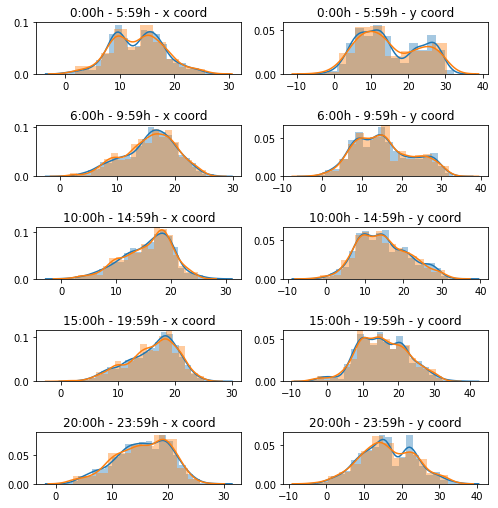

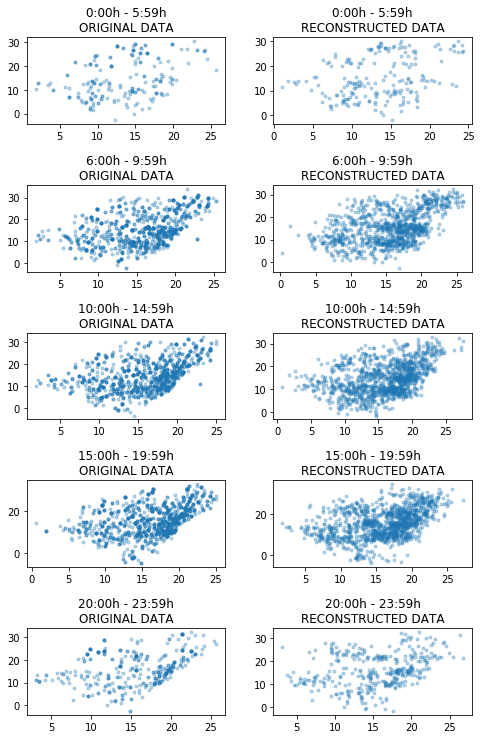

In [13]:
generate_single_dist_plts(n, df, to_csv, time_zones, inicio)
generate_dist_plts(n, df, to_csv, time_zones, inicio)

# ============================================================
# =========== if you're happy with the result, export it to csv ============

In [14]:
export(to_csv, inicio)

# ============================ end ============================